In [1]:
# This notebook looks into how existing vanilla transformers do math

In [2]:
import torch
device='cuda'
torch.nn.Sequential(
        torch.nn.Linear(in_features=256, out_features=4*10),
        torch.nn.Sigmoid()
    ).to(device)

Sequential(
  (0): Linear(in_features=256, out_features=40, bias=True)
  (1): Sigmoid()
)

In [3]:
# ----- dependencies
!pip install transformers 
#!pip install git+https://github.com/huggingface/transformers #accelerate deepspeed
!pip install -U huggingface_hub
!pip install -U accelerate
!pip install --upgrade pip
!pip install torch

  Using cached tokenizers-0.14.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached huggingface_hub-0.17.3-py3-none-any.whl.metadata (13 kB)
Using cached tokenizers-0.14.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.8 MB)
Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.0
    Uninstalling tokenizers-0.13.0:
      Successfully uninstalled tokenizers-0.13.0
  Using cached huggingface_hub-0.18.0-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.18.0-py3-none-any.whl (301 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstall

In [4]:
!pip install tokenizers==0.13.0 # may need 14 or 13 depending on python version. 13 works with python 3.8

  Using cached tokenizers-0.13.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (7.0 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.1
    Uninstalling tokenizers-0.14.1:
      Successfully uninstalled tokenizers-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.35.0.dev0 requires tokenizers<0.15,>=0.14, but you have tokenizers 0.13.0 which is incompatible.


In [5]:
# ----- dependencies
import os
import torch
from transformers import LlamaModel, LlamaConfig, LlamaForCausalLM
from huggingface_hub import login
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# --- character-level tokenizer
class Char_Tokenizer():

    def __init__(self):
        self.chars = ['<pad>','<s>','</s>','0','1','2','3','4','5','6','7','8','9','+','=',' ']
        self.bos_token=1
        self.eos_token=2
        self.pad_token=0
        self.vocab_size = len(self.chars)
        self.char2idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx2char = {i: ch for i, ch in enumerate(self.chars)}

    def tokenize(self, text, max_length=None):
        list = [self.char2idx[ch] for ch in text]
        list.insert(0,self.bos_token) # prefix <s>
        list.append(self.eos_token) # suffix </s>
        if max_length is None:
            return list
        else: # padding/cropping if max length is specified
            list += [self.pad_token for i in range(max(0,max_length-len(list)))]
            list = list[0:max_length]
            return list
    
    def detokenize(self, ids):
        return "".join([self.idx2char[i] for i in ids])
    
tokenizer = Char_Tokenizer()
vocab_size = tokenizer.vocab_size


In [11]:

# ----- HYPERPARAMETERS
LLM_context_length = 20 
LLM_hid =      256 # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to smalltansformers
LLM_layers =   4
LLM_n_heads =  4

# --- training
batch_size = 256
iterations = 10000
epochs = 1


In [14]:
# ------- Initialize model


# --- Create non-causal concept encoder (C) (tokens to concepts)
# the final autorecressive decoder-only model will use itself as the encoder - note that for char-level or removing tokenizer dependency we will need a separate encoder so that decoder take in only high level concepts
half_config = LlamaConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=LLM_hid,
    intermediate_size=LLM_hid*4,
    num_hidden_layers=LLM_layers,
    num_attention_heads=LLM_n_heads,
    num_key_value_heads=None,
    hidden_act='silu',
    max_position_embeddings=LLM_context_length,
    initializer_range=0.02,
    rms_norm_eps=1e-06,
    use_cache=True,
    pad_token_id=None,
    bos_token_id=tokenizer.bos_token,
    eos_token_id=tokenizer.eos_token,
    pretraining_tp=1,
    tie_word_embeddings=False,
    rope_theta=10000.0,
    rope_scaling=None)

# --- Create causal concept decoder (D) (concepts to concepts)
LLM_decoder = LlamaForCausalLM(half_config).to(device)#.to(torch.bfloat16)
LLM_decoder.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(16, 256)
    (layers): ModuleList(
      (0-3): 4 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=256, out_features=256, bias=False)
          (k_proj): Linear(in_features=256, out_features=256, bias=False)
          (v_proj): Linear(in_features=256, out_features=256, bias=False)
          (o_proj): Linear(in_features=256, out_features=256, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=256, out_features=1024, bias=False)
          (up_proj): Linear(in_features=256, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=256, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_fea

In [12]:
import random

eval_pairs = []

for i in range((2000//batch_size)*batch_size):
    eval_pairs.append((random.randint(0, 999), random.randint(0, 999)))

len(eval_pairs)

1792

In [ ]:
LLM_decoder = torch.load('transfo_add')
1/0

In [15]:
# ------- TRAINING RUN
from transformers import top_k_top_p_filtering
import random


# --- Define the optimizer and loss function
optimizer = optim.AdamW(LLM_decoder.parameters(), lr=1e-4, betas=(0.9,0.99), weight_decay=0.1) # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to small transformers
warmup_iters = 100 # pre-ln transformers dont need warmup # # learning rate decay scheduler (cosine with warmup) from karpathy's nano-gpt
lr_decay_iters = iterations
learning_rate = 0.001
min_lr = 1e-5
import math
def get_lr(it):
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)



losses = []
accs = []
eval_losses = []
eval_accs = []
generations = []

LLM_decoder.train()
it = 0
for _ in range(epochs):
    for b in range(iterations):

        # get batch x, y
        batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
        for b_idx in range(batch_size):
            num1,num2=eval_pairs[0]
            while ((num1,num2) in eval_pairs) or ((num2,num1) in eval_pairs):            
                num1 = random.randint(0, 9999)
                num2 = random.randint(0, 9999)
            result = str(num1 + num2)
            problem = f"{num1}+{num2}={result}"
            tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
            batch_input_ids[b_idx][:] = torch.tensor(tokenized)
        labels = batch_input_ids.clone()
        labels[labels==tokenizer.pad_token] = -100

        # update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = get_lr(it)

        # forward pass
        # force interpretability via attention sparsity ?
        output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token
        loss = output.loss
    

        # Iterate through each sample in the batch
        b_accs=[]
        for s in range(batch_size):
            # Find the index of the token with value 14 in the 'labels' tensor for the current sample
            index_14 = (labels[s] == 14).nonzero(as_tuple=True)
            index_14 = index_14[0][0]
            # Calculate accuracy only for tokens after index_14 for the current sample
            predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
            correct_predictions = (predicted_labels[index_14+1:] == labels[s, index_14+1:].roll(-1, dims=0)).float()
            # Calculate the accuracy for tokens after index_14 for the current sample
            b_accs.append(correct_predictions.mean().item())
        accs.append(torch.tensor(b_accs).mean().item())

        # Step 5: Train D on the modified inputs and token labels
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        losses.append(loss.item())

        it += 1

        # GET GENERATION SAMPLES (not optimized w/ cache):
        if it%100==0:
            with torch.no_grad():
                LLM_decoder.eval()



                # =============== EVAL LOSS
                total_batch_acc = []
                for eval_batch in range(0, len(eval_pairs), batch_size):
                    batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
                    for b_idx in range(batch_size):
                        num1,num2 = eval_pairs[eval_batch + b_idx]
                        result = str(num1 + num2)
                        problem = f"{num1}+{num2}={result}"
                        tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
                        batch_input_ids[b_idx][:] = torch.tensor(tokenized)
                    labels = batch_input_ids.clone()
                    labels[labels==tokenizer.pad_token] = -100

                    # forward pass
                    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token
                    loss = output.loss
                    eval_losses.append(loss.item())

                    # GET ACC
                    b_accs=[]
                    for s in range(batch_size):
                        # Find the index of the token with value 14 in the 'labels' tensor for the current sample
                        index_14 = (labels[s] == 14).nonzero(as_tuple=True)
                        index_14 = index_14[0][0]
                        eos = (labels[s] == tokenizer.eos_token).nonzero(as_tuple=True)
                        eos = eos[0][0]
                        # Calculate accuracy only for tokens after index_14 for the current sample
                        predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
                        predicted_number = predicted_labels[index_14:eos-1]
                        correct_number = labels[s,index_14+1:eos]
                        predicted_number = tokenizer.detokenize(predicted_number.tolist())
                        correct_number = tokenizer.detokenize(correct_number.tolist()) 
                        #print('Y_:'+predicted_number)
                        #print('Y:'+correct_number)
                        #print()
                        
                        # whole number acc
                        if True:
                            try:
                                b_accs.append(float(int(predicted_number)==int(correct_number)))
                            except:
                                b_accs.append(0)
                        # per digit acc
                        else:
                            correct_predictions = (predicted_labels[index_14:eos-1] == labels[s, index_14+1:eos]).float()
                            b_accs.append(correct_predictions.mean().item())
                    total_batch_acc.append(torch.tensor(b_accs).mean().item())
                eval_accs.append(torch.tensor(total_batch_acc).mean().item())


                # ============================================================================ GENERATIVE AUTOREGRESSIVE INFERENCE
                input_ids = torch.tensor([[tokenizer.bos_token]])
                while input_ids.shape[1] < LLM_context_length:
                    output = LLM_decoder(input_ids=input_ids.to(device))
                    logits = output.logits.cpu()
                    next_token_logits = logits[:, -1, :]
                    next_token_id = torch.multinomial(torch.softmax(next_token_logits, dim=-1), 1)
                    input_ids = torch.cat([input_ids, next_token_id], dim=1)
                print(tokenizer.detokenize(input_ids[0].tolist()))
                LLM_decoder.train()

                print(it,':', eval_losses[-1], eval_accs[-1], 'lr',get_lr(it))


<s>196+743=1129</s></s></s></s></s></s></s>
100 : 1.701456069946289 0.0033482143189758062 lr 0.001
<s>499+84=1+15=6341</s></s>2
200 : 1.7443112134933472 0.0050223213620483875 lr 0.0009997507884796767
<s>53+376=455</s></s></s></s></s></s>8</s></s>
300 : 1.5681005716323853 0.00390625 lr 0.0009990034048535828
<s>40+974=1028</s></s></s></s></s></s></s></s>
400 : 1.5467019081115723 0.004464285913854837 lr 0.0009977586016736769
<s>130+234=422</s></s></s></s></s></s></s></s>
500 : 1.5282288789749146 0.01171875 lr 0.0009960176323512437
<s>755+11=787</s></s></s></s></s>7</s></s></s>
600 : 1.38627028465271 0.1261160671710968 lr 0.0009937822498948153
<s>770+973=1743</s></s></s>+74</s>
700 : 1.180195927619934 0.8247767686843872 lr 0.0009910547051450397
<s>672+157=925</s></s></s></s></s></s></s></s>
800 : 1.1729457378387451 0.8660714030265808 lr 0.0009878377445082765
<s>946+602=1548</s></s></s></s>+9</s>
900 : 1.1583731174468994 0.8917410969734192 lr 0.0009841346071911964
<s>438+328=766</s></s></s>

In [16]:
torch.save(LLM_decoder, 'transfo_add')

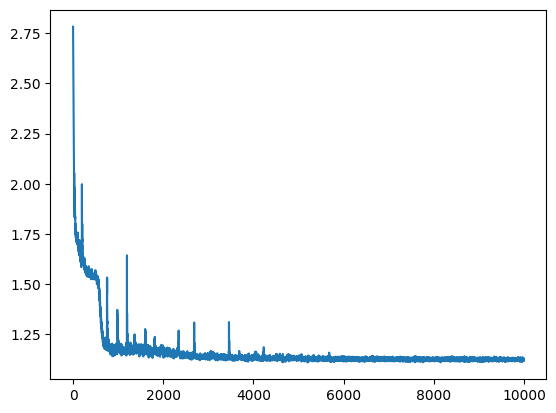

In [18]:
import matplotlib.pyplot as plt
plt.plot(losses)

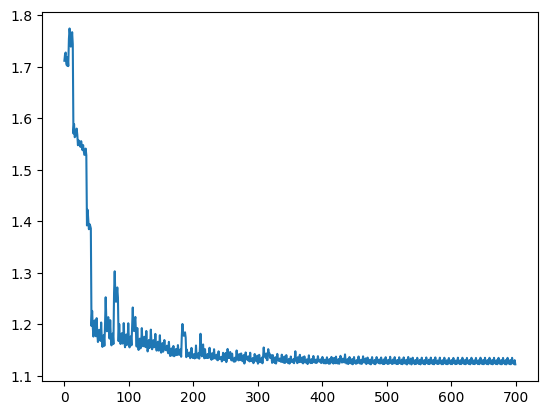

In [19]:
plt.plot(eval_losses)

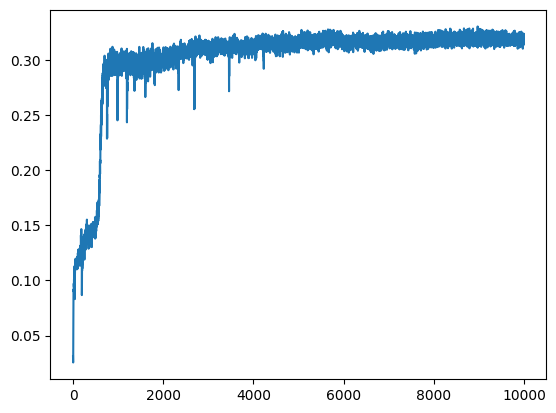

In [20]:
plt.plot(accs)

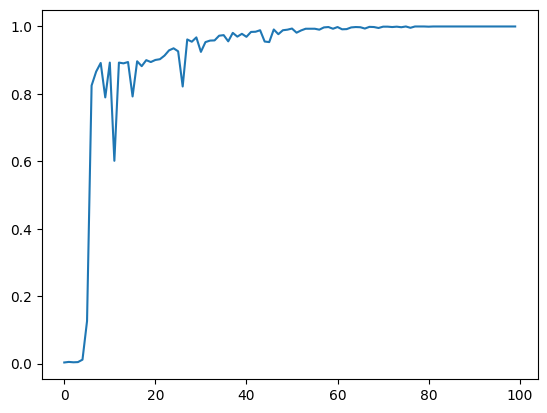

In [21]:
plt.plot(eval_accs)

In [22]:
import sys
!{sys.executable} -m pip install bertviz


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: /media/idmi/Z/Ubuntu_folder/miniconda3/envs/minerl/bin/python -m pip install --upgrade pip


In [23]:
from bertviz import model_view

# create math input
batch_input_ids = torch.zeros([1,LLM_context_length],dtype=torch.long)
num1 = random.randint(0, 999)
num2 = random.randint(0, 999)
result = str(num1 + num2)
problem = f"{num1}+{num2}={result}"
tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
batch_input_ids[0][:] = torch.tensor(tokenized)

labels = batch_input_ids.clone()
labels[labels==tokenizer.pad_token] = -100

# forward pass
LLM_decoder.eval()
with torch.no_grad():
    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device), output_attentions=True) 
attention = output[-1]

a=tokenizer.detokenize(tokenized)
print(a)
model_view(attention, a.replace('<s>', '_').replace('</s>', '_').replace('<pad>', '_'))


<s>802+187=989</s><pad><pad><pad><pad><pad><pad><pad>


<IPython.core.display.Javascript object>

In [ ]:
# plot linear probe success at finding number

# in order to interpret how the network calculates, we attempt to identify wher different parts of the answer are calculated, specifically looking at all transfo block outputs at every layer at every timestep 

# we decide to look for where the following calculations are completed:
# - we will be unlikely to identify a location where the final answer is stored, because the answer is likely distributed among the tokens - the network is unlikely to store the entire answer in a single hidden activation.
# We search for this anyway, training a linear probe with a neurons for each possible digit for each  digit position (since we max out at 1998 here, we train with 4 digits * 10)
# it is likely that even if the entire answer is not stored in a hidden activation, we can recover the value of a single digit at a single location

# we only train the probe on sequences the network is correct on

In [90]:

# ------- TRAINING RUN
import random


# -- linear probe. Train one per layer, each probe is train on all token positions in its respective layer
linear_probes=[]
optimizers = []
cuda_streams = [] # we want to train different matrices in parallel
for l in range(LLM_layers):
    linear_probes.append(
        torch.nn.Sequential(
            torch.nn.Linear(in_features=256, out_features=4*10),
        ).to(device)
    )
    optimizers.append(optim.Adam(linear_probes[l].parameters(), lr=1e-5)) # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to small transformers
    cuda_streams.append(torch.cuda.Stream())

# learning rate. why would I use a complicated learning rate like this on a linear probe? just for fun.
import math
learning_rate=1e-4
lr_decay_iters=10000
warmup_iters=100
min_lr = 1e-5
def get_lr(it):
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)


criterion = torch.nn.CrossEntropyLoss()

probe_losses = []
probe_accs = []

LLM_decoder.eval()
it = 0
for _ in range(epochs):
    for b in range(iterations):

        # get batch x, y
        batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
        results=[]
        for b_idx in range(batch_size):
            num1,num2=eval_pairs[0]
            while ((num1,num2) in eval_pairs) or ((num2,num1) in eval_pairs):            
                num1 = random.randint(0, 999)
                num2 = random.randint(0, 999)
            result = str(num1 + num2)
            results.append(result)
            problem = f"{num1}+{num2}={result}"
            tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
            batch_input_ids[b_idx][:] = torch.tensor(tokenized)
        labels = batch_input_ids.clone()
        labels[labels==tokenizer.pad_token] = -100


        # forward pass
        # force interpretability via attention sparsity?
        with torch.no_grad():
            output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device), output_hidden_states=True) # just start with first token

        # update learning rate
        for o in range(LLM_layers):
            for param_group in optimizers[o].param_groups:
                param_group['lr'] = get_lr(it)

        xs = []
        ys = []
        formatted_results = ["{:04d}".format(int(ans)) for ans in results]
        for l in range(LLM_layers):
            x = output.hidden_states[l] # get activations at layer l - should have shape [B, T, E]
            y = torch.full([x.shape[0], x.shape[1], 4, 10], 0.01, device=device) # given a hidden state, linear probe tries to guess the value of each digit at each position

            #x = x[:,6:12]
            #y = y[:,6:12]

            # linear probe is trained to estimate the full final answer at every timestep.
            for b, ans in enumerate(formatted_results):
                for d in range(4):
                    digit_ans = int(formatted_results[b][d])
                    y[b,:,d,digit_ans] = 0.99
            
            x = x.reshape([x.shape[0]*x.shape[1],LLM_hid])
            y = y.reshape([y.shape[0]*y.shape[1], 4, 10])

            xs.append(x) # write x,y to arrays so we don't mutate them during parallel training
            ys.append(y)

            with torch.cuda.stream(cuda_streams[l]):
                y_ = linear_probes[l](xs[l])
                y_ = y_.reshape([y_.shape[0], 4, 10]) # reshape from [B,40] to [B,4,10]

                loss=0
                for d in range(4):
                    loss += criterion(y_[:,d,:], ys[l][:,d,:])
                loss/=4
                probe_losses.append(loss.item())

                loss.backward()
                optimizers[l].step()
                optimizers[l].zero_grad(set_to_none=True)
                loss=0

                y = y.reshape(batch_size, LLM_context_length, 4, 10)
                y_ = y_.reshape(batch_size, LLM_context_length, 4, 10)

                acc = (y.argmax(dim=-1)==y_.argmax(dim=-1)).half().mean().item()
                probe_accs.append(acc)
                
        torch.cuda.synchronize()
        del xs, ys, 
        it += 1

        if it%100==0:
            print(it, probe_losses[-1], probe_accs[-1])









        if False:
            with torch.no_grad():

                # =============== EVAL LOSS
                total_batch_acc = []
                for eval_batch in range(0, len(eval_pairs), batch_size):
                    batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
                    for b_idx in range(batch_size):
                        num1,num2 = eval_pairs[eval_batch + b_idx]
                        result = str(num1 + num2)
                        problem = f"{num1}+{num2}={result}"
                        tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
                        batch_input_ids[b_idx][:] = torch.tensor(tokenized)
                    labels = batch_input_ids.clone()
                    labels[labels==tokenizer.pad_token] = -100

                    # forward pass
                    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token
                    loss = output.loss
                    eval_losses.append(loss.item())

                    # GET ACC
                    b_accs=[]
                    for s in range(batch_size):
                        # Find the index of the token with value 14 in the 'labels' tensor for the current sample
                        index_14 = (labels[s] == 14).nonzero(as_tuple=True)
                        index_14 = index_14[0][0]
                        eos = (labels[s] == tokenizer.eos_token).nonzero(as_tuple=True)
                        eos = eos[0][0]
                        # Calculate accuracy only for tokens after index_14 for the current sample
                        predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
                        predicted_number = predicted_labels[index_14:eos-1]
                        correct_number = labels[s,index_14+1:eos]
                        predicted_number = tokenizer.detokenize(predicted_number.tolist())
                        correct_number = tokenizer.detokenize(correct_number.tolist()) 
                        #print('Y_:'+predicted_number)
                        #print('Y:'+correct_number)
                        #print()
                        
                        # whole number acc
                        if True:
                            try:
                                b_accs.append(float(int(predicted_number)==int(correct_number)))
                            except:
                                b_accs.append(0)
                        # per digit acc
                        else:
                            correct_predictions = (predicted_labels[index_14:eos-1] == labels[s, index_14+1:eos]).float()
                            b_accs.append(correct_predictions.mean().item())
                    total_batch_acc.append(torch.tensor(b_accs).mean().item())
                eval_accs.append(torch.tensor(total_batch_acc).mean().item())

                print(it,':', eval_losses[-1], eval_accs[-1], 'lr',get_lr(it))


100 2.834888219833374 0.161865234375
200 2.3050308227539062 0.227294921875
300 2.177665948867798 0.254638671875
400 2.1330137252807617 0.2783203125
500 2.115152359008789 0.2802734375
600 2.0961248874664307 0.29443359375
700 2.0780553817749023 0.29931640625
800 2.0705196857452393 0.298828125
900 2.0716991424560547 0.303466796875
1000 2.0643198490142822 0.304443359375
1100 2.057138204574585 0.3056640625
1200 2.0434672832489014 0.3154296875
1300 2.0585379600524902 0.309326171875
1400 2.0521280765533447 0.3154296875
1500 2.0433895587921143 0.31787109375
1600 2.040079355239868 0.323974609375
1700 2.0393762588500977 0.324951171875
1800 2.0434398651123047 0.314208984375
1900 2.046266555786133 0.318603515625
2000 2.0283455848693848 0.3291015625
2100 2.0301175117492676 0.31982421875
2200 2.030399799346924 0.3330078125
2300 2.026813507080078 0.331787109375
2400 2.03572678565979 0.322265625
2500 2.027071714401245 0.334228515625
2600 2.027648448944092 0.333251953125
2700 2.017442464828491 0.339599

In [91]:
for l in range(LLM_layers):
    torch.save(linear_probes[l], f'lprobe{l}')

In [ ]:
for i in range(LLM_context_length):
    linear_probes[l] = torch.load(f'lprobe{l}')

FileNotFoundError: [Errno 2] No such file or directory: 'lprobe0'

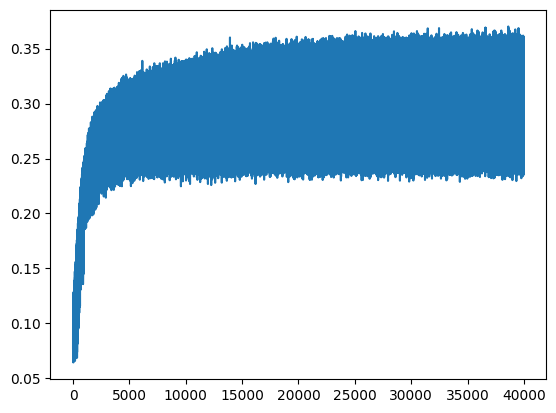

In [92]:
import matplotlib.pyplot as plt
plt.plot(probe_accs)

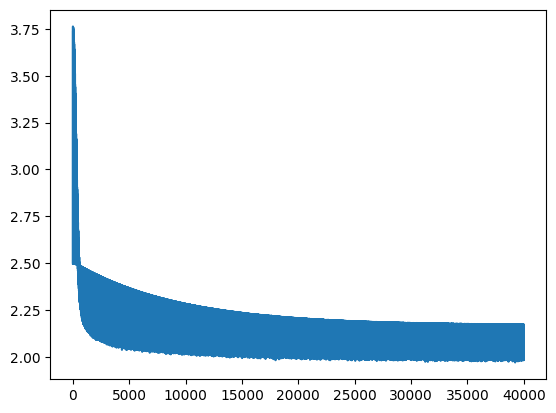

In [93]:
plt.plot(probe_losses)

In [ ]:
# SCALE THE ACCURACIES OF PROBE PREDICTIONS

# remember that if a probe is shown abc+ijk=xyz, given just the first number, if the second digit is small (0), you have a decent change of the first number being the same as the first number in the final answer.
# if digit 1 is 0, the second numbers first digit must be 0 and the 2nd digit can be between 0 and 9 and the final answer will ahve the same number. 
# P(ANSd0=NUM1d0|NUM1d1=0) = P(NUM2d0=0)=1/10 * P(NUM2d1d2+NUM1d1d2<100)=10/10 *
# P(ANSd0=NUM1d0|NUM1d1=5) = 1/10 * 10/10 

In [89]:
# display
def ANSI_func(brightness):
    if brightness > 0.6:
        return '\033[92m'  # Green
    elif brightness > 0.3:
        return '\033[93m'  # Yellow
    else:
        return '\033[91m'  # Red
    


# get batch x, y
batch_input_ids = torch.zeros([1,LLM_context_length],dtype=torch.long)
results=[]
num1 = 500
num2 = 500
if ((num1,num2) in eval_pairs) or ((num2,num1) in eval_pairs):
    print("this sample is in eval!")
result = str(num1 + num2)
results.append(result)
problem = f"{num1}+{num2}={result}"
tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
batch_input_ids[0][:] = torch.tensor(tokenized)
labels = batch_input_ids.clone()
labels[labels==tokenizer.pad_token] = -100


# forward pass
# force interpretability via attention sparsity?
with torch.no_grad():
    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device), output_hidden_states=True) # just start with first token

xs = []
ys = []
formatted_results = ["{:04d}".format(int(ans)) for ans in results]
print(formatted_results)

for l in range(LLM_layers-1, -1, -1):
    print()
    x = output.hidden_states[l] # get activations at layer l - should have shape [B, T, E]
    y = torch.full([x.shape[0], x.shape[1], 4, 10], 0.01, device=device) # given a hidden state, linear probe tries to guess the value of each digit at each position

    # linear probe is trained to estimate the full final answer at every timestep.
    for b, ans in enumerate(formatted_results):
        for d in range(4):
            digit_ans = int(formatted_results[b][d])
            y[b,:,d,digit_ans] = 0.99
    
    x = x.reshape([x.shape[0]*x.shape[1],LLM_hid])
    y = y.reshape([y.shape[0]*y.shape[1], 40])

    xs.append(x) # write x,y to arrays so we don't mutate them during parallel inference
    ys.append(y)

    with torch.cuda.stream(cuda_streams[l]):
        with torch.no_grad():
            y_ = linear_probes[l](xs[(LLM_layers-1)-l]).reshape([1, LLM_context_length, 4, 10]) # reshape from [B,40] to [B,4,10]
        y_ = torch.nn.Softmax(dim=-1)(y_)
        estimated_ds = y_.argmax(dim=-1)
        certainty_ds = y_.amax(dim=-1)
    
    for t in range(LLM_context_length):
        estimated_d = ''.join([str(digit) for digit in estimated_ds[0, t].tolist()])
        for d in range(4):
            print(f"{ANSI_func(certainty_ds[0,t,d])}{estimated_d[d]}", end='')
        print('\t',end='')
    #print(y_[0,:,0,:].argmax(dim=-1))

print()
for i in range(len(problem)):
    print(problem[i]+'\t',end='')

        
torch.cuda.synchronize()
del xs, ys, 
it += 1

['1000']

3031	1123	1123	1946	0097	1329	0610	0610	0093	1099	1002	1000	0009	0909	0921	0921	1921	0921	0991	0900	
0933	1052	1053	1054	0327	1421	0110	0610	1004	1112	1000	1000	0000	0900	0900	0900	0900	0201	0900	0900	
0000	0007	1000	1006	0776	0481	0500	0601	1003	1000	0000	1000	1000	0000	0000	0000	0000	0000	0000	0000	
6598	0555	1000	1000	6691	0555	1000	1000	0324	1111	1000	1000	1000	0608	0311	0311	0311	0311	0311	0311	
5	0	0	+	5	0	0	=	1	0	0	0	

In [83]:
tokenizer.detokenize(output.logits[0,6:12].argmax(dim=-1).tolist()[1:])

'=1022'

In [ ]:
accuracy_when_ablated = 